<a href="https://colab.research.google.com/github/yardenfren1996/B-LoRA/blob/main/B_LoRA_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#for training must use this version
!pip install -q diffusers==0.25.0 
!pip install bitsandbytes

In [ ]:
#for no training
!pip install --upgrade diffusers transformers accelerate

In [ ]:
!git clone https://github.com/yardenfren1996/B-LoRA.git
%cd B-LoRA

In [ ]:
pwd

In [ ]:
#diy run once
%mkdir yin

In [ ]:
pwd

In [ ]:
%cd yin
!git clone https://github.com/RongWenYin/B-LoRA.git

In [ ]:
%cd B-LoRA

In [ ]:
#diy synchronize ,update latest code from github
!git pull

In [ ]:
def filter_lora_diy(state_dict):
    try:
        return {k: v for k, v in state_dict.items() if True}
    except Exception as e:
        raise type(e)(f'failed to filter_lora, due to: {e}')
        

In [ ]:
#diy This is a one-time only operation
import transformers
transformers.utils.move_cache()

In [ ]:

import matplotlib.pyplot as plt

def plot_images(images, titles=None, figsize=(15, 5)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)

    for i, img in enumerate(images):
        axes[i].imshow(img)
        if titles:
            axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.show()

In [ ]:
import torch
from diffusers import StableDiffusionXLPipeline, AutoencoderKL
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)


In [ ]:
def load_b_lora_to_unet(pipe, content_lora_model_id: str = '', style_lora_model_id: str = '', content_alpha: float = 1.,
                            style_alpha: float = 1.) -> None:
        try:
            #diy
#             pipe.enable_peft()
            
            # Get Content B-LoRA SD
            if content_lora_model_id:
                content_B_LoRA_sd, _ = pipe.lora_state_dict(content_lora_model_id)
                content_B_LoRA = filter_lora(content_B_LoRA_sd, BLOCKS['content'])
                content_B_LoRA = scale_lora(content_B_LoRA, content_alpha)
            else:
                content_B_LoRA = {}

            # Get Style B-LoRA SD
            if style_lora_model_id:
                style_B_LoRA_sd, _ = pipe.lora_state_dict(style_lora_model_id)
                print('use b-lorra..')
                style_B_LoRA = filter_lora(style_B_LoRA_sd, BLOCKS['style'])
                style_B_LoRA = scale_lora(style_B_LoRA, style_alpha)
            else:
                style_B_LoRA = {}

            # Merge B-LoRAs SD
            res_lora = {**content_B_LoRA, **style_B_LoRA}

            # Load
            pipe.load_lora_into_unet(res_lora, None, pipe.unet)
        except Exception as e:
            raise type(e)(f'failed to load_b_lora_to_unet, due to: {e}')

In [ ]:
def load_normal_lora(pipe, style_lora_model_id: str = '') -> None:
        try:
            pipe.unload_lora_weights()

            # Get Style B-LoRA SD
            if style_lora_model_id:
                style_B_LoRA_sd, _ = pipe.lora_state_dict(style_lora_model_id)
                print('use normal lora')
                
            else:
                style_B_LoRA = {}
            # Load
            pipe.load_lora_into_unet(style_B_LoRA_sd, None, pipe.unet)
        except Exception as e:
            raise type(e)(f'failed to load_b_lora_to_unet, due to: {e}')

## Image Stylization Based On Image Style Reference

In [ ]:
#diy need install first
!pip install -U peft

In [ ]:
content_B_LoRA_path = ''
style_B_LoRA_path = 'TheLastBen/Papercut_SDXL'
content_alpha,style_alpha = 1,1.1

In [ ]:
load_b_lora_to_unet(pipeline, content_B_LoRA_path, style_B_LoRA_path, content_alpha, style_alpha)

In [ ]:
prompt = 'A tiger in papercut style'
image = pipeline(prompt,generator=torch.Generator(device="cuda").manual_seed(48), num_images_per_prompt=1).images[0].resize((512,512))
image

In [ ]:
load_normal_lora(pipeline, style_B_LoRA_path)

In [ ]:
prompt = 'A bird in papercut style'
image = pipeline(prompt,generator=torch.Generator(device="cuda").manual_seed(148), num_images_per_prompt=1).images[0].resize((512,512))
image

In [ ]:
load_b_lora_to_unet(pipeline, content_B_LoRA_path, style_B_LoRA_path, content_alpha, style_alpha)

In [ ]:
prompt = 'A bird in papercut style'
image = pipeline(prompt,generator=torch.Generator(device="cuda").manual_seed(148), num_images_per_prompt=1).images[0].resize((512,512))
image

In [ ]:
pipeline_ori = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        vae=vae,
        torch_dtype=torch.float16,
    ).to("cuda")

In [ ]:
prompt = 'A bird in papercut style'
image = pipeline_ori(prompt,generator=torch.Generator(device="cuda").manual_seed(148), num_images_per_prompt=1).images[0].resize((512,512))
image

In [ ]:
model_path_ori="TheLastBen/Papercut_SDXL"
style_B_LoRA_sd_ori, _ = pipeline_ori.lora_state_dict(model_path_ori)
style_B_LoRA_ori=filter_lora_diy(style_B_LoRA_sd_ori)

res_lora_ori = {**style_B_LoRA_ori}

pipeline_ori.load_lora_into_unet(res_lora_ori, None, pipeline_ori.unet)
prompt = 'A bird in papercut style'
image = pipeline_ori(prompt,generator=torch.Generator(device="cuda").manual_seed(148), num_images_per_prompt=1).images[0].resize((512,512))
image

In [ ]:

pipeline_ori.fuse_lora()
model_path_ori="TheLastBen/Papercut_SDXL"
pipeline_ori.load_lora_weights(tcd_lora_id)
prompt = 'A bird in papercut style'
image = pipeline_ori(prompt,generator=torch.Generator(device="cuda").manual_seed(148), num_images_per_prompt=1).images[0].resize((512,512))
image

In [ ]:
 #diy PEFT backend is required for this method.
!pip install peft

In [ ]:
pipeline.unload_lora_weights()

## Image Stylization Based On Text Reference

In [ ]:
!pwd

In [ ]:
!accelerate launch train_dreambooth_b-lora_sdxl.py \
 --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
 --instance_data_dir="/kaggle/input/style-view" \
 --output_dir="outputsview" \
 --instance_prompt="ssvviiee_onlyu1" \
 --resolution=1024 \
 --rank=64 \
 --train_batch_size=1 \
 --learning_rate=5e-5 \
 --lr_scheduler="constant" \
 --lr_warmup_steps=0 \
 --max_train_steps=1000 \
 --checkpointing_steps=500 \
 --seed="0" \
 --gradient_checkpointing \
 --use_8bit_adam \
 --mixed_precision="fp16"

In [10]:
blockType="allblocks"
prompt_key="ffooxx"
styleName=f'{prompt_key}_{blockType}'
output_dir=f'foutputsview_{blockType}'

In [ ]:

#diy customer training

!accelerate launch train_dreambooth_b-lora_sdxl.py \
 --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
 --instance_data_dir="/kaggle/input/style-view" \
 --output_dir=output_dir \
 --instance_prompt=styleName \
 --resolution=1024 \
 --rank=64 \
 --train_batch_size=1 \
 --learning_rate=5e-5 \
 --lr_scheduler="constant" \
 --lr_warmup_steps=0 \
 --max_train_steps=1000 \
 --checkpointing_steps=500 \
 --seed="0" \
 --gradient_checkpointing \
 --use_8bit_adam \
 --mixed_precision="fp16" \
 --cust_block_list="down_blocks.2.attentions.1 up_blocks.0.attentions.1"

In [ ]:

#diy customer training-all blocks
!accelerate launch train_dreambooth_b-lora_sdxl.py \
 --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
 --instance_data_dir="/kaggle/input/xm-style-fox" \
 --output_dir=output_dir \
 --instance_prompt=f'{prompt_key}_{blockType}' \
 --resolution=1024 \
 --rank=64 \
 --train_batch_size=1 \
 --learning_rate=5e-5 \
 --lr_scheduler="constant" \
 --lr_warmup_steps=0 \
 --max_train_steps=1000 \
 --checkpointing_steps=500 \
 --seed="0" \
 --gradient_checkpointing \
 --use_8bit_adam \
 --mixed_precision="fp16" \
 --cust_block_list="down_blocks.2.attentions.0 down_blocks.2.attentions.1 up_blocks.0.attentions.0 up_blocks.0.attentions.1 up_blocks.0.attentions.2"

In [ ]:
print(output_dir)

In [ ]:
print(style_B_LoRA_path)

In [1]:
%cd yin/B-LoRA

/kaggle/working/yin/B-LoRA


In [3]:
# content_B_LoRA_path = 'lora-library/B-LoRA-teddybear'
# style_B_LoRA_path = 'lora-library/B-LoRA-pen_sketch'
# content_B_LoRA_path = 'outputkelly/pytorch_lora_weights.safetensors'
content_B_LoRA_path = ''
style_B_LoRA_path = f'output_dir/pytorch_lora_weights.safetensors'
content_alpha,style_alpha = 1,1.1

In [7]:
def is_belong_to_blocks(key, blocks):
    try:
        for g in blocks:
            if g in key:
                return True
        return False
    except Exception as e:
        raise type(e)(f'failed to is_belong_to_block, due to: {e}')


def filter_lora(state_dict, blocks_):
    try:
        return {k: v for k, v in state_dict.items() if is_belong_to_blocks(k, blocks_)}
    except Exception as e:
        raise type(e)(f'failed to filter_lora, due to: {e}')


def scale_lora(state_dict, alpha):
    try:
        return {k: v * alpha for k, v in state_dict.items()}
    except Exception as e:
        raise type(e)(f'failed to scale_lora, due to: {e}')


def get_target_modules(unet, blocks=None):
    try:
        if not blocks:
            blocks = [('.').join(blk.split('.')[1:]) for blk in BLOCKS['content'] + BLOCKS['style']]

        attns = [attn_processor_name.rsplit('.', 1)[0] for attn_processor_name, _ in unet.attn_processors.items() if
                 is_belong_to_blocks(attn_processor_name, blocks)]

        target_modules = [f'{attn}.{mat}' for mat in ["to_k", "to_q", "to_v", "to_out.0"] for attn in attns]
        return target_modules
    except Exception as e:
        raise type(e)(f'failed to get_target_modules, due to: {e}')

In [2]:
import torch
from diffusers import StableDiffusionXLPipeline, AutoencoderKL
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)


2024-08-27 05:52:25.701608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 05:52:25.701723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 05:52:25.829296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
#diy must run when generating images
pipeline = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        vae=vae,
        torch_dtype=torch.float16,
    ).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [24]:
#down_blocks.2.attentions.0 down_blocks.2.attentions.1 
#up_blocks.0.attentions.0 up_blocks.0.attentions.1 up_blocks.0.attentions.2
BLOCKS_STYLE = {
    'content': ['unet.up_blocks.0.attentions.0'],
#     'style': ['unet.up_blocks.0.attentions.1','unet.down_blocks.2.attentions.1'],
    'style': ['down_blocks.2.attentions.1'],
}

def load_style_to_unet(pipe, style_lora_model_id: str = '', content_alpha: float = 1.,
                            style_alpha: float = 1.) -> None:
        try:
            # Get Style B-LoRA SD
            if style_lora_model_id:
                style_B_LoRA_sd, _ = pipe.lora_state_dict(style_lora_model_id)
                print('use b-lorra..')
                style_B_LoRA = filter_lora(style_B_LoRA_sd, BLOCKS_STYLE['style'])
                print('use block style..',BLOCKS_STYLE['style'])
                style_B_LoRA = scale_lora(style_B_LoRA, style_alpha)
            else:
                style_B_LoRA = {}

            # Merge B-LoRAs SD
            res_lora = {**style_B_LoRA}

            # Load
            pipe.load_lora_into_unet(res_lora, None, pipe.unet)
        except Exception as e:
            raise type(e)(f'failed to load_b_lora_to_unet, due to: {e}')

In [25]:
#diy
load_style_to_unet(pipeline, style_B_LoRA_path, content_alpha, style_alpha)

use b-lorra..
use block style.. ['down_blocks.2.attentions.1']


In [ ]:
print(prompt_key,blockType,styleName)

a girl in ffooxx_allblocks style


  0%|          | 0/50 [00:00<?, ?it/s]

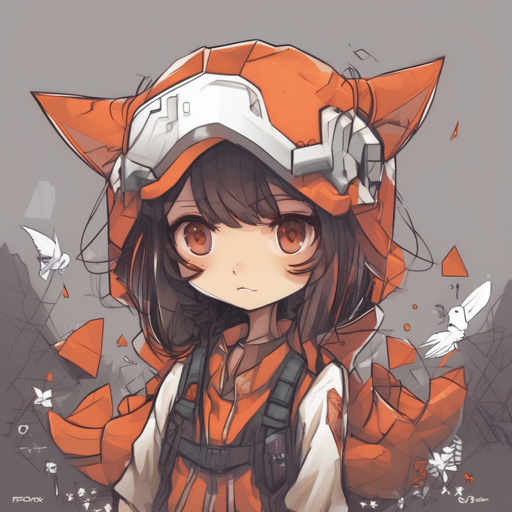

In [27]:
# prompt = 'A [v18] in [v30] style'
styleName=f'{prompt_key}_{blockType}'
# objectName="fox"
objectName="girl"
prompt = f'a {objectName} in {styleName} style'
print(prompt)
image = pipeline(prompt,generator=torch.Generator(device="cuda").manual_seed(138), num_images_per_prompt=1).images[0].resize((512,512))
image.save(f'{styleName}_{objectName}____D2A1.png')
image

In [ ]:
# prompt = 'A [v18] in [v30] style'
styleName=f'ssvviiee_{blockType}'
prompt = f'A house in {styleName} style'
image = pipeline(prompt,generator=torch.Generator(device="cuda").manual_seed(138), num_images_per_prompt=1).images[0].resize((512,512))
image.save(styleName+"1.png")
image